In [52]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

# **Loading and analysing data**

In [71]:
#Load data
data = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")

In [72]:
#Here we can see that it images were encoded by rle and NaN rows mean that's image without ship
#Adding new column which can show is ship in image
data['has_sheep']=data['EncodedPixels'].notna().astype(int)

data.head()

,ImageId,EncodedPixels,has_sheep
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1


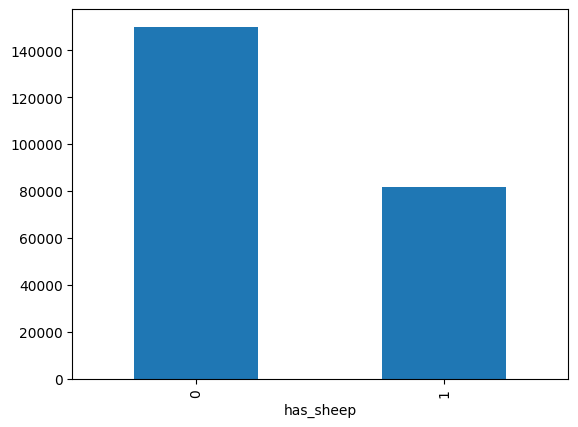

has_sheep
0    150000
1     81723
Name: count, dtype: int64

In [73]:
#Let's count and compare images
#Ass we see images without ship more than it present, that can do disbalance in our model
ship_count = data['has_sheep'].value_counts()
ship_count.plot(kind='bar')
plt.show()
ship_count

In [74]:
#So, we need to cut some data to improve accuracy in our model
#It will bee 9000 pictures with ships and 1000 without
empty, has_ships = 1000, 9000
df = pd.concat([data[data["EncodedPixels"].isna()].sample(empty), data[~data["EncodedPixels"].isna()].sample(has_ships)])
df.shape

(10000, 3)

# **Train Data Generator**

In [75]:
SIZE_FULL = 768 # original dataset's images size
SIZE = 256 #size used for using in model (3x3 squares to make original image)
IMG_CHANNELS = 3 # image channels

In [76]:
def crop3x3(img, i):
    """img: np.ndarray - original image 768x768
       i: int 0-8 - image index from crop: 0 1 2
                                           3 4 5
                                           6 7 8
       returns: image 256x256 
    """
    return img[(i//3)*SIZE: ((i//3)+1)*SIZE,(i%3)*SIZE: (i%3+1)*SIZE]


def crop3x3_mask(img):
    """Returns crop image, crop index with maximum ships area"""
    i = K.argmax((
        K.sum(crop3x3(img, 0)),
        K.sum(crop3x3(img, 1)),
        K.sum(crop3x3(img, 2)),
        K.sum(crop3x3(img, 3)),
        K.sum(crop3x3(img, 4)),
        K.sum(crop3x3(img, 5)),
        K.sum(crop3x3(img, 6)),
        K.sum(crop3x3(img, 7)),
        K.sum(crop3x3(img, 8)),
    ))
    return (crop3x3(img, i), i)

In [77]:
# https://www.kaggle.com/code/stainsby/fast-tested-rle/notebook
def decode(mask_rle):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    img=np.zeros(SIZE_FULL*SIZE_FULL, dtype=np.float32)
    if not(type(mask_rle) is float):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1.0
    return img.reshape((SIZE_FULL, SIZE_FULL)).T

In [78]:
class TrainDataGenerator(tfk.utils.Sequence):
    '''
    This class allows to efficiently prepare and receive batches of data for model training, 
    which is important when working with large amounts of data, such as training image sets
    '''
    
    def __init__(self, datapath ,batch_size, df_mask: pd.DataFrame):
        self.datapath = datapath
        self.batch_size = batch_size
        self.df =  df_mask.sample(frac=1)
        self.l = len(self.df)//batch_size

    def __len__(self):
        return self.l

    def on_epoch_end(self):
        pass

    def __getitem__(self, index):
        mask = np.empty((self.batch_size, SIZE , SIZE), np.float32)
        image = np.empty((self.batch_size, SIZE, SIZE, 3), np.float32)
        
        for b in range(self.batch_size):
            temp = tfk.preprocessing.image.load_img(self.datapath + '/' + self.df.iloc[index*self.batch_size+b]['ImageId'])
            temp = tfk.preprocessing.image.img_to_array(temp)/255
        
            mask[b], i = crop3x3_mask( # decoding mask from run-length format, and cropping part with maximum ship's area(№ i)
                decode(
                    self.df.iloc[index*self.batch_size+b]['EncodedPixels']
                )
            ) 
            image[b] = crop3x3(temp, i) # using corresponding to mask crop of image (№ i)
            
        return image, mask

# ***U-NET***

In [79]:
def dice_score(y_true, y_pred):
    '''calculating dice score, will used for evaluate model'''
    return (2.0*K.sum(y_pred * y_true)+0.0001) / (K.sum(y_true)+ K.sum(y_pred)+0.0001)

In [80]:
def BFCE_dice(y_true, y_pred):
    return  K.binary_focal_crossentropy(y_true, y_pred)+  (1-dice_score(y_true, y_pred))*0.1

In [81]:
def BCE_dice(y_true, y_pred):
    return  K.binary_crossentropy(y_true, y_pred)+  (1-dice_score(y_true, y_pred))

In [82]:
# dropout = 0.2
dropout = 0.2

k =2
def dconv(prev, filters, kernel_size=3):
    prev = tfl.BatchNormalization()(prev)
    prev = tfl.Conv2D(filters, kernel_size, padding="same", activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Dropout(dropout)(prev)
    prev = tfl.Conv2D(filters, kernel_size, padding="same", activation="elu", kernel_initializer= 'he_normal')(prev)
    return prev
    


def down(prev, filters, kernel_size=3): 
    skip = dconv(prev, filters, kernel_size)
    prev = tfl.MaxPool2D(strides=2, padding='valid')(skip)
    return prev, skip


def bridge(prev, filters,kernel_size=3):  
    prev = dconv(prev, filters, kernel_size)
    prev = tfl.Conv2DTranspose(filters // 2, 2, strides=(2, 2))(prev)
    return prev


def up(prev, skip, filters, kernel_size=3):  
    prev = tfl.concatenate([prev, skip], axis=3) 
    prev = tfl.Dropout(dropout)(prev)
    prev = dconv(prev, filters, kernel_size)
    prev = tfl.Conv2DTranspose(filters // 2, 2, strides=(2, 2))(prev)
    return prev


def last(prev, skip, filters,kernels_size=(3,3)):
    prev = tfl.concatenate([prev, skip], axis=3)
    prev = tfl.Dropout(dropout)(prev)
    prev = tfl.Conv2D(filters, kernels_size[0], padding="same",activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Conv2D(filters, kernels_size[1], padding="same",activation="elu", kernel_initializer= 'he_normal')(prev)
    prev = tfl.Conv2D(filters=1, kernel_size=1,padding="same", activation="sigmoid")(prev)
    return prev


def unet_model(input_shape):
    inp = tfk.Input(shape=input_shape)
    inp = tfl.BatchNormalization()(inp)
    out, skip_1 = down(inp, k*16)
    out, skip_2 = down(out, k*32)
    out, skip_3 = down(out, k*64)
    out, skip_4 = down(out, k*128)
    out = bridge(out, k*256)
    out = up(out, skip_4, k*128)
    out = up(out, skip_3, k*64)
    out = up(out, skip_2, k*32)
    out = last(out, skip_1, k*16)

    model = tfk.Model(inputs=inp, outputs=out)
    return model

In [85]:
#Split data to train test
batch_size = 16
X_train, Y_train = train_test_split(df, test_size=0.2)
X_train = TrainDataGenerator("/kaggle/input/airbus-ship-detection/train_v2", batch_size, X_train)
Y_train = TrainDataGenerator("/kaggle/input/airbus-ship-detection/train_v2", batch_size, Y_train)
model = unet_model((SIZE, SIZE, 3))

In [86]:
#Compile model
model.compile(tf.keras.optimizers.Adam(0.0001) , BCE_dice  , dice_score)

In [159]:
#Set up callback
callback = tfk.callbacks.ModelCheckpoint("./models/model.{epoch:02d}-{val_loss:.4f}-dice:{val_dice_score:.4f}.h5", "val_loss", save_best_only=True, save_weights_only=True)

In [88]:
#Fit model
history = model.fit(X_train, validation_data=Y_train, batch_size = batch_size,epochs=24,verbose=1, callbacks=[callback] )

Epoch 1/24


2024-02-11 17:44:44.006473: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707673491.654128     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 427s 811ms/step - loss: 0.7503 - dice_score: 0.3596 - val_loss: 0.6597 - val_dice_score: 0.4368
Epoch 2/24
500/500 [==============================] - 302s 604ms/step - loss: 0.6056 - dice_score: 0.4766 - val_loss: 0.6333 - val_dice_score: 0.4472
Epoch 3/24
500/500 [==============================] - 299s 598ms/step - loss: 0.5688 - dice_score: 0.5076 - val_loss: 0.6172 - val_dice_score: 0.4563
Epoch 4/24
500/500 [==============================] - 300s 601ms/step - loss: 0.5386 - dice_score: 0.5337 - val_loss: 0.6075 - val_dice_score: 0.4790
Epoch 5/24
500/500 [==============================] - 302s 604ms/step - loss: 0.5180 - dice_score: 0.5518 - val_loss: 0.5465 - val_dice_score: 0.5228
Epoch 6/24
500/500 [==============================] - 301s 602ms/step - loss: 0.4945 - dice_score: 0.5719 - val_loss: 0.5401 - val_dice_score: 0.5325
Epoch 7/24
500/500 [==============================] - 299s 599ms/step - loss: 0.4844 - dice_score: 0.5804 - val

In [89]:
#Save model
model.save('my_unet_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


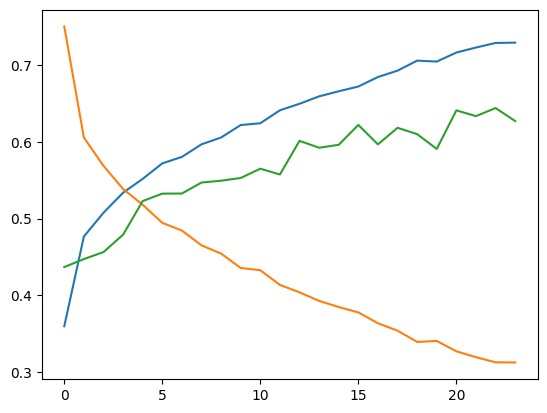

In [90]:
#Plott evaluation of the model
L = []
L.extend(history.history['loss'])

S = []
S.extend(history.history['dice_score'])

V = []
V.extend(history.history['val_dice_score'])

plt.plot(S)
plt.plot(L)
plt.plot(V)

# ***Prediction and compare masks***

1/1 [==============================] - 0s 27ms/step


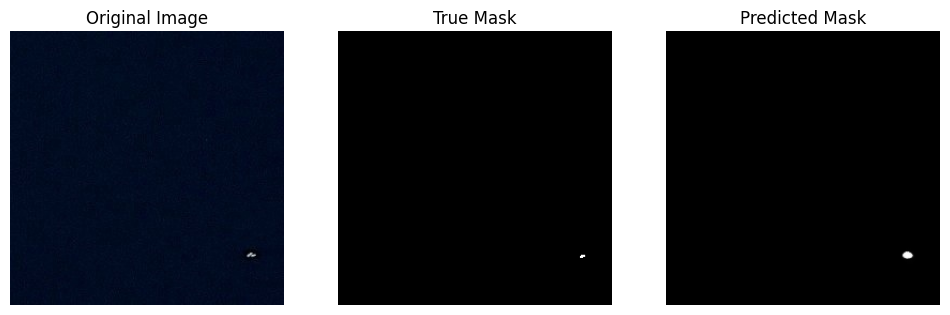

1/1 [==============================] - 0s 32ms/step


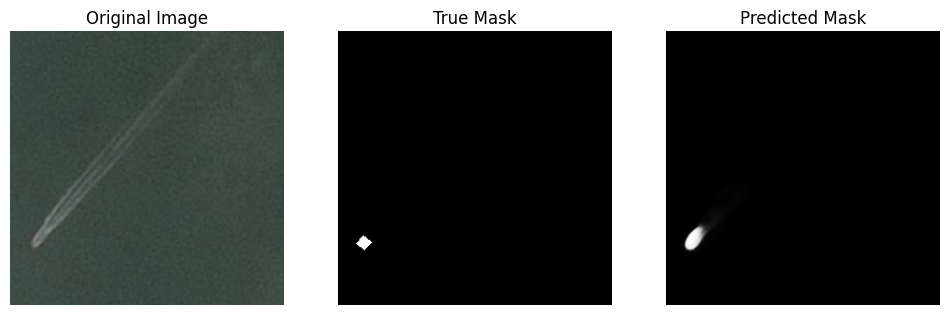

1/1 [==============================] - 0s 26ms/step


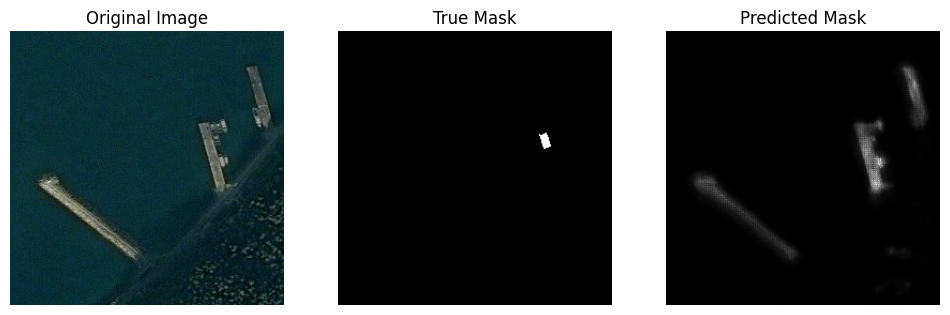

1/1 [==============================] - 0s 25ms/step


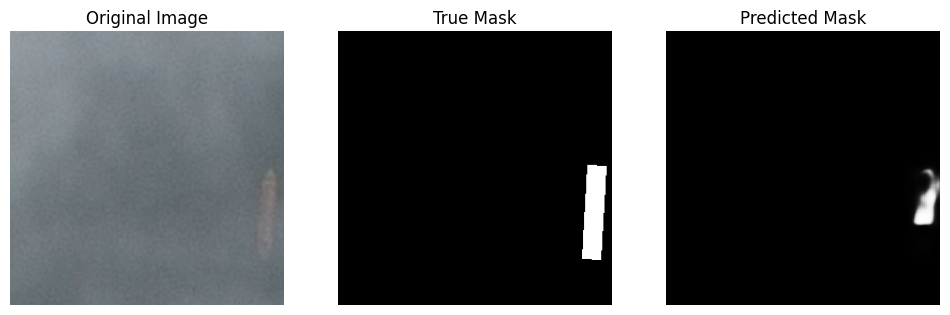

1/1 [==============================] - 0s 27ms/step


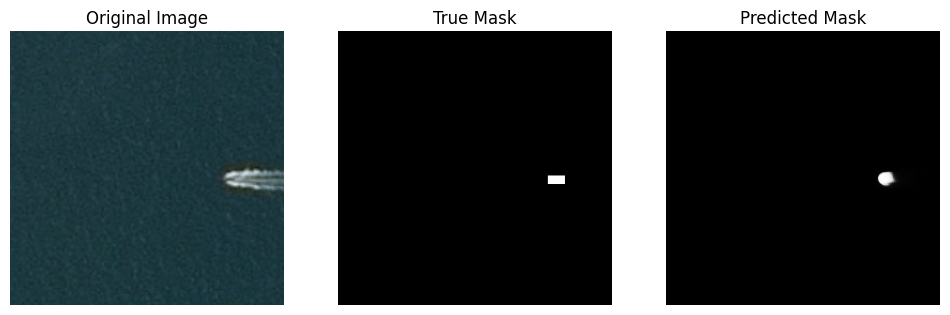

In [160]:
import random

# Chose 5 random pictures
random_indexes = random.sample(range(len(X_train)), 5)

# Iterate in indexes
for index in random_indexes:
    input_image, true_mask = X_train[index]
    predicted_mask = model.predict(input_image)

    # Plot origynal image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(input_image[0])
    plt.axis('off')

    # Plot origynal mask
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask[0], cmap='gray')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask[0], cmap='gray')
    plt.axis('off')

    plt.show()